In [2]:
#import the tree parser
import baltic_four as bt

#load other relevant libraries for plotting
import numpy as np
print np.__version__
import re
from scipy.special import binom
import matplotlib as mpl
import matplotlib.pyplot as plt
print mpl.__version__
%matplotlib inline

from matplotlib import font_manager as fm
fm.findfont('Helvetica')

1.11.2
1.5.1


u'/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf'

In [4]:
tree_path='/Users/alliblk/Desktop/baltic_tryout/env_roka_controls_skygrid50_strictclock_200Mburn200.mcc'
print "File: %s"%(tree_path.split('/')[-1]) #make sure I have the right file

File: env_roka_controls_skygrid50_strictclock_200Mburn200.mcc


In [5]:
tipFlag=False ## used to keep track of where we are in FigTree format
tips={} ## dictionary of tip code to full tip name

for line in open(tree_path,'rU'): ## iterate through FigTree file's lines
    line = line.strip('\n') ## strip newline characters from each line
    tip_count_match =re.search('dimensions ntax=([0-9]+);',line.lower()) ## check how many tips you have
    #print tip_count
    if tip_count_match is not None:
        tipNum=int(tip_count_match.group(1)) 

print tipNum

230


In [6]:
for line in open(tree_path,'rU'):
    line = line.strip('\n')
    tree_string_match =re.search('tree TREE([0-9]+) = \[&R\]',line) ## search for beginning of tree string in BEAST format
    if tree_string_match is not None:
        treeString_start = line.index('(') ## tree string starts where the first '(' is in the line
        #print treeString_start
        linked_list = bt.tree() ## new instance of tree
        bt.make_tree(line[treeString_start:],linked_list) ## send tree string to make_tree function, provide an empty tree object

In [7]:
for line in open(tree_path,'rU'):
    line = line.strip('\n')
    if tipFlag==True:
        tip_match = re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|?]+)',line) 
        ## look for tip name map, where each tip is given an integer to represent it in tree
        if tip_match is not None:
            tips[tip_match.group(1)]=tip_match.group(2).strip("'") 
            ## if you give tips an integer (in the form of a string), it will return the full name of the tip
        elif ';' not in line: ## something's wrong - nothing that matches the tip regex is being captured where it should be in the file
            print 'tip not captured by regex:',line.replace('\t','')

    if 'translate' in line.lower(): ## start looking for tips, the tips text block is starting 
        tipFlag=True
    if ';' in line: ## stop looking for tips, the tips text block has ended
        tipFlag=False

print "Number of objects found in tree string: %d"%(len(linked_list.Objects))
#print tips

Number of objects found in tree string: 459


In [90]:
if len(tips)==0: ## use this if tip names in the string are already the final format
    for k in linked_list.Objects:
        if isinstance(k,leaf):
            k.name=k.numName
    highestTip=max([bt.decimalDate(x.name.strip("'").split('|')[-1],variable=True) for x in linked_list.Objects if isinstance(x,leaf)])
else: ## there's a tip name map at the beginning, so translate the names (so that you're not using the taxon numbers)
    linked_list.renameTips(tips) ## give each tip a name
    highestTip=max([bt.decimalDate(x.strip("'").split('|')[-1],variable=True) for x in tips.values()])
print highestTip

linked_list.sortBranches(descending=False) #sorts branches and automatically draws tree.

linked_list.setAbsoluteTime(highestTip) #set absolute time based off of most recent leaf.
print 'Highest tip date: %.4f'%(highestTip) #and check that that's correct.

2015.0739726
Highest tip date: 2015.0740


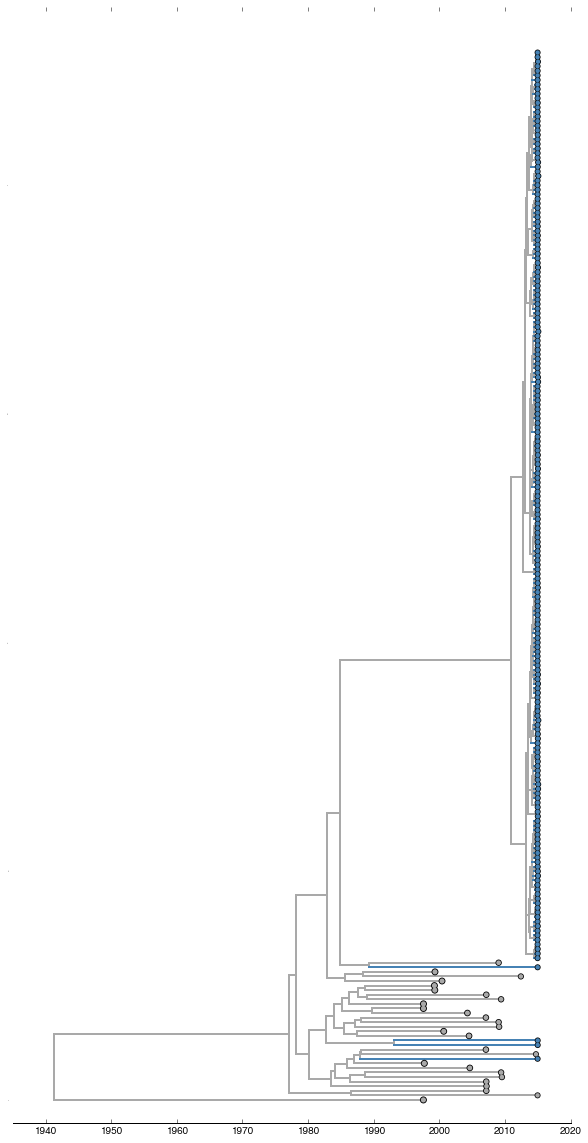

In [9]:
linked_list.sortBranches(descending=False)
#set plotting parameters and plotting area
fig,ax = plt.subplots(figsize=(10,20),facecolor='white')
branchWidth=2 ## default branch width

# iterate over the branches
# x and y relate to dimensions when plotting, x is based on sampling date, y is arbitrary
# and just allows expansion of the tree at even widths (y coords not informative in a tree)
# each node in the tree (internal and leaves) will have an (x,y) coordinate.
for k in linked_list.Objects:
    x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    xp=k.parent.absoluteTime ## get x position of current node's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    #c= 'blue' #color can be fixed across trait
    #or color can be applied by traits
    #color = cmap(k.height/linked_list.treeHeight)
    if k.branchType == 'leaf' and k.name.split('|')[1] == 'roka':
        color = 'steelblue'
    else:
        color = 'darkgrey'
    

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        #s=50 ## tip size can be fixed
        s=50-30*k.height/linked_list.treeHeight #or size can be relative
        
        ax.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=color,ls='-',zorder=9)
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color=color,ls='-',zorder=9)

#Remove lines from sides of plot that I don't like
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='top',labelsize=0,size=0)

ax.set_xlim(1935,2020)
ax.set_ylim(-5,len(linked_list.Objects)/2+10)


plt.show()

In [10]:
#this will assign the roka trait 
for k in linked_list.Objects:
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        if k.name.split('|')[1] == "control":
            k.traits["sample_type"] = 'control'
        elif k.name.split('|')[1] == "roka":
            k.traits["sample_type"] = 'roka'
    elif isinstance(k,bt.node) or k.branchType =='node':
       continue 

for k in linked_list.Objects:
    if isinstance(k,bt.node) or k.branchType =='node':
        if len(k.leaves) == 2:
            roka_count = 0
            for leaf in k.leaves:
                if tips[leaf].split('|')[1] == 'roka':
                    roka_count += 1
            if roka_count == 2:
                k.traits['sample_type'] = 'roka'
            elif roka_count < 2:
                k.traits['sample_type'] = 'control'

for i in xrange(2,len(linked_list.Objects)):
    for k in linked_list.Objects:
        if isinstance(k,bt.node) or k.branchType =='node':
            if len(k.leaves) == i:
                roka_count = 0
                for leaf in k.leaves:
                    if tips[leaf].split('|')[1] == 'roka':
                        roka_count += 1
                if roka_count == i:
                    k.traits['sample_type'] = 'roka'
                elif roka_count < i:
                    k.traits['sample_type'] = 'control'

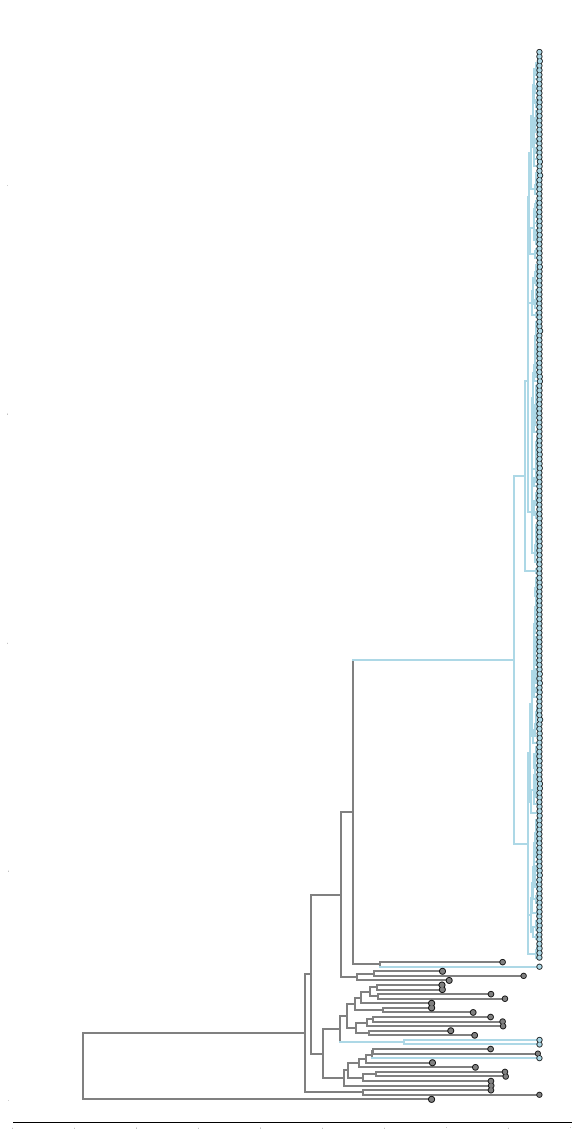

In [11]:
fig,ax = plt.subplots(figsize=(10,20),facecolor='w')
branchWidth=2 ## default branch width

# iterate over the branches
# x and y relate to dimensions when plotting, x is based on sampling date, y is arbitrary
# and just allows expansion of the tree at even widths (y coords not informative in a tree)
# each node in the tree (internal and leaves) will have an (x,y) coordinate.
for k in linked_list.Objects:
    x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    xp=k.parent.absoluteTime ## get x position of current node's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    #c= 'blue' #color can be fixed across trait
    #or color can be applied by traits
    color = 'grey'
    if k.traits['sample_type'] == 'roka':
        color = 'lightblue'
    else:
        color = 'grey'
    

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        #s=50 ## tip size can be fixed
        s=50-30*k.height/linked_list.treeHeight #or size can be relative
        
        ax.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=color,ls='-',zorder=9)
        #ax.text(x,y,'%.2f'%(k.traits['height_median']),va='top',ha='right',size=14)
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color=color,ls='-',zorder=9)

#Remove lines from sides of plot that I don't like
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',labelsize=0,size=0)
ax.tick_params(axis='y',labelsize=0,size=0)

ax.set_ylim(-5,len(linked_list.Objects)/2+10)

plt.show()

In [12]:
roka_nonia = ['NCHADS116', 'NCHADS171', 'NCHADS184', 'NCHADS185']
roka_outbreak = []
for k in linked_list.Objects:
    if isinstance(k,bt.leaf) or k.branchType == 'leaf':
        if k.name.split('|')[0] not in roka_nonia and k.name.split('|')[1] == 'roka':
            roka_outbreak.append(k.name)

print len(roka_outbreak)
print roka_outbreak[:3]

199
['NCHADS114|roka|env|2014-12-17', 'NCHADS173|roka|env|2014-12-19', 'NCHADS124|roka|env|2014-12-17']


In [13]:
#tips is the dictionary I have linking numNames to realNames.

#linked list is my tree object
#tipMap is a method of tree objects. 
linked_list.tipMap=tips

#commonAncestor is also a method of tree objects, takes a list
#note you can specify whether the list is of numNames or actual names.
#default is numNames = FALSE, here I'm making that explicit.

roka_outbreak_mrca = linked_list.commonAncestor(roka_outbreak,False)

#check out the age of that node using the absoluteTime method of nodes.
print roka_outbreak_mrca.absoluteTime


2010.91074169


In [60]:
#designate which font to use. To use others just use different ttf files 
#if ttf files not already in there, may need to do fondu conversion of dfont files and move in.
font_path = '/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/HelveticaNeueThin.ttf'
font_properties = fm.FontProperties(fname=font_path)
print font_properties
mpl.rcParams['font.family'] = font_properties.get_name()

#designate some font characteristics
mpl.rcParams['font.weight']=100
mpl.rcParams['axes.labelweight']=100
mpl.rcParams['font.size']=14


:family=Helvetica Neue:style=normal:variant=normal:weight=100:stretch=normal:file=/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/HelveticaNeueThin.ttf:size=14.0


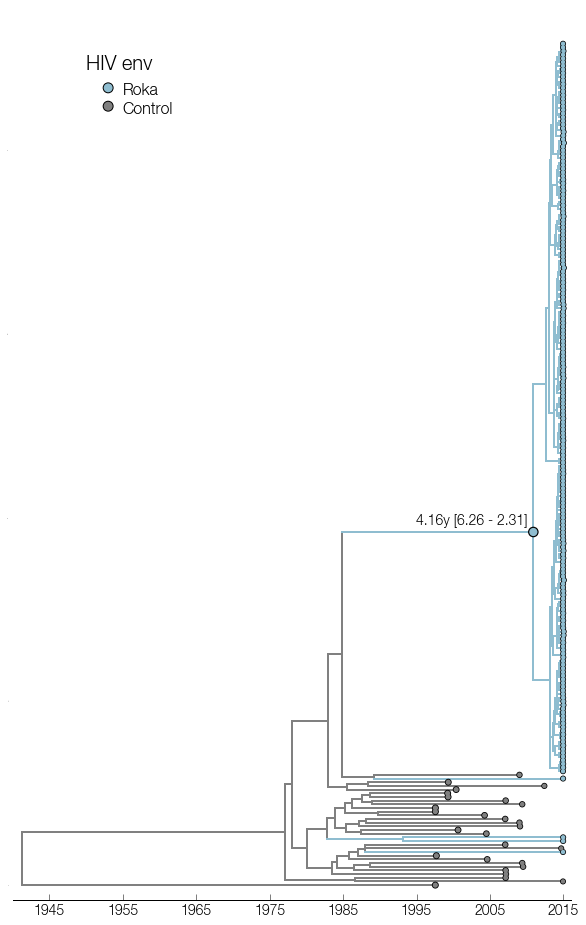

In [222]:
#set up the plotting space
fig,ax = plt.subplots(figsize=(10,16),facecolor='white')
#set branch widths
branchWidth=2 #I tried out others, this looks the best.

#plot the tree
#x relates to sampling date, y is arbitrary and calc'd to separate tips evenly
for k in linked_list.Objects:
    #determine x and y coordinates for nodes and leaves
    x=k.absoluteTime
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    xp=k.parent.absoluteTime ## get x position of current node's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    #set up branch and node coloring.
    color = 'grey'
    if k.traits['sample_type'] == 'roka':
        color = '#8FBDD0'#'lightblue'
    else:
        color = 'grey'
    
    # iterate through and draw the tree
    #draw leaves with circles
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        s=50-30*k.height/linked_list.treeHeight #s is the size of the tip circle
        ax.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip, highest zorder means on top of everything else
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath (zorder is one less than face zorder)
    #draw nodes
    elif isinstance(k,bt.node) or k.branchType=='node':
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=color,ls='-',zorder=9)
        #draw a circle on a specific node and annotate
        if k == roka_outbreak_mrca:
            ax.scatter(x,y,s=3*s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for node
            ax.scatter(x,y,s=5*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            node_age_string = '{0:.2f}y'.format(k.traits['height_median']) + ' ' +'[{0:.2f} - {1:.2f}] '.format(k.traits['height_95%_HPD'][1],k.traits['height_95%_HPD'][0])
            ax.text(x-16,y+2,node_age_string,size=14)
            #add time to x and subtract something for y (0.2 yrs etc) va='top',ha='right'
    #plot the rest of the branches   
    ax.plot([xp,x],[y,y],lw=branchWidth,color=color,ls='-',zorder=9) #branches should be plotted beneath tip circles.

#Remove lines from sides of plot that I don't like
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# decide which axis labels and ticks should be visible on plot
ax.tick_params(axis='x',labelsize=14,size=6)
ax.tick_params(axis='y',labelsize=0,size=0)

#format axis limits
major_ticks = np.arange(1935, 2016, 10)                                              
ax.set_xticks(major_ticks)                                                       
                                         
# Only show ticks on the bottom spine
ax.xaxis.set_ticks_position('bottom')     

ax.set_ylim(-4,len(linked_list.Objects)/2+10)
ax.set_xlim(1940,2016)

#make legend
ax.text(1950,222, 'HIV env', size=20)
ax.text(1955,215, 'Roka', size=16)
ax.text(1955,210, 'Control', size=16)

ax.scatter(1953,217,s=80,facecolor='#8FBDD0',edgecolor='none',zorder=11) ## plot circle for node
ax.scatter(1953,217,s=120,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath
ax.scatter(1953,212,s=80,facecolor='grey',edgecolor='none',zorder=11) ## plot circle for node
ax.scatter(1953,212,s=120,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath

plt.show()
plt.figure()
fig.savefig('env_timetree.pdf')

## Next up, make those timetrees for HCV!

In [77]:
# Read in mcc files 
HCV6e_mcc_path='/Users/alliblk/Desktop/gitrepos/roka/HCV/bayesian_timetree/HCV6e_strict_BS10_burn200.mcc'
HCV1b_mcc_path='/Users/alliblk/Desktop/gitrepos/roka/HCV/bayesian_timetree/HCV1b_strict_BS10_burn200.mcc'

tipFlag=False ## used to keep track of where we are in FigTree format
hcv6e_tips={} ## dictionary of tip code to full tip name
hcv1b_tips={}

for line in open(HCV6e_mcc_path,'rU'): ## iterate through FigTree file's lines
    line = line.strip('\n') ## strip newline characters from each line
    tip_count_match =re.search('dimensions ntax=([0-9]+);',line.lower()) ## check how many tips you have
    #print tip_count
    if tip_count_match is not None:
        tipNum=int(tip_count_match.group(1)) 

print 'number of tips in HCV6e tree: ' + str(tipNum)

for line in open(HCV1b_mcc_path,'rU'): ## iterate through FigTree file's lines
    line = line.strip('\n') ## strip newline characters from each line
    tip_count_match =re.search('dimensions ntax=([0-9]+);',line.lower()) ## check how many tips you have
    #print tip_count
    if tip_count_match is not None:
        tipNum=int(tip_count_match.group(1)) 

print 'number of tips in HCV1b tree: ' + str(tipNum)

number of tips in HCV6e tree: 72
number of tips in HCV1b tree: 76


In [72]:
for line in open(HCV6e_mcc_path,'rU'):
    line = line.strip('\n')
    tree_string_match =re.search('tree TREE([0-9]+) = \[&R\]',line) ## search for beginning of tree string in BEAST format
    if tree_string_match is not None:
        treeString_start = line.index('(') ## tree string starts where the first '(' is in the line
        #print treeString_start
        hcv6e_tree = bt.tree() ## new instance of tree
        bt.make_tree(line[treeString_start:],hcv6e_tree) ## send tree string to make_tree function, provide an empty tree object

for line in open(HCV1b_mcc_path,'rU'):
    line = line.strip('\n')
    tree_string_match =re.search('tree TREE([0-9]+) = \[&R\]',line) ## search for beginning of tree string in BEAST format
    if tree_string_match is not None:
        treeString_start = line.index('(') ## tree string starts where the first '(' is in the line
        #print treeString_start
        hcv1b_tree = bt.tree() ## new instance of tree
        bt.make_tree(line[treeString_start:],hcv1b_tree)

FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree comment found, ignoring
FigTree 

In [79]:
for line in open(HCV6e_mcc_path,'rU'):
    line = line.strip('\n')
    if tipFlag==True:
        tip_match = re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|?]+)',line) 
        ## look for tip name map, where each tip is given an integer to represent it in tree
        ## note that if you're reading in a file that was read in figtree this won't be there
        ## you'll just have the proper names there.
        if tip_match is not None:
            hcv6e_tips[tip_match.group(1)]=tip_match.group(2).strip("'")
            ## if you give tips an integer (in the form of a string), it will return the full name of the tip
        elif ';' not in line: ## something's wrong - nothing that matches the tip regex is being captured where it should be in the file
            print 'tip not captured by regex:',line.replace('\t','')

    if 'translate' in line.lower(): ## start looking for tips, the tips text block is starting 
        tipFlag=True
    if ';' in line: ## stop looking for tips, the tips text block has ended
        tipFlag=False

print "Number of objects found in hcv6e tree string: %d"%(len(hcv6e_tree.Objects))

#########

for line in open(HCV1b_mcc_path,'rU'):
    line = line.strip('\n')
    if tipFlag==True:
        tip_match = re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|?]+)',line) 
        ## look for tip name map, where each tip is given an integer to represent it in tree
        if tip_match is not None:
            hcv1b_tips[tip_match.group(1)]=tip_match.group(2).strip("'") 
        elif ';' not in line: ## something's wrong - nothing that matches the tip regex is being captured where it should be in the file
            print 'tip not captured by regex:',line.replace('\t','')

    if 'translate' in line.lower(): ## start looking for tips, the tips text block is starting 
        tipFlag=True
    if ';' in line: ## stop looking for tips, the tips text block has ended
        tipFlag=False

print "Number of objects found in hcv1b tree string: %d"%(len(hcv1b_tree.Objects))


Number of objects found in hcv6e tree string: 143
Number of objects found in hcv1b tree string: 151


In [89]:
#assign the dates to the leaves.
#Remember to change the .split depending on where the date info is in the taxon label
#starting with HCV6e

if len(hcv6e_tips)==0: ## use this if tip names in the string are already the final format (eg figtree file)
    for k in hcv6e_tree.Objects:
        if isinstance(k,bt.leaf):
            k.name=k.numName
    highestTip6e=max([bt.decimalDate(x.name.strip("'").split('|')[1],variable=True) for x in hcv6e_tree.Objects if isinstance(x,bt.leaf)])
else: ## there's a tip name map at the beginning, so translate the names (so that you're not using the taxon numbers)
    hcv6e_tree.renameTips(hcv6e_tips) ## give each tip a name
    highestTip6e=max([bt.decimalDate(x.strip("'").split('|')[1],variable=True) for x in hcv6e_tips.values()])
print 'HCV6e highest tip is : ' + str(highestTip6e)

#HCV1b now.
if len(hcv1b_tips)==0: ## use this if tip names in the string are already the final format (eg figtree file)
    for k in hcv1b_tree.Objects:
        if isinstance(k,bt.leaf):
            k.name=k.numName
    highestTip1b=max([bt.decimalDate(x.name.strip("'").split('|')[1],variable=True) for x in hcv1b_tree.Objects if isinstance(x,bt.leaf)])
else: ## there's a tip name map at the beginning, so translate the names (so that you're not using the taxon numbers)
    hcv1b_tree.renameTips(hcv1b_tips) ## give each tip a name
    highestTip1b=max([bt.decimalDate(x.strip("'").split('|')[1],variable=True) for x in hcv1b_tips.values()])
print 'HCV1b highest tip is : ' + str(highestTip1b)

HCV6e highest tip is : 2015.01917808
HCV1b highest tip is : 2015.03561644


In [144]:
hcv6e_tree.sortBranches(descending=False) #sorts branches and automatically draws tree.
hcv6e_tree.setAbsoluteTime(highestTip6e) #set absolute time based off of most recent leaf.
print 'Highest tip date: %.4f'%(highestTip6e) #and check that that's correct.

hcv1b_tree.sortBranches(descending=False) #sorts branches and automatically draws tree.
hcv1b_tree.setAbsoluteTime(highestTip6e) #set absolute time based off of most recent leaf.
print 'Highest tip date: %.4f'%(highestTip1b) #and check that that's correct.

Highest tip date: 2015.0192
Highest tip date: 2015.0356


### Differentiate roka sequences from controls

NCHADS ID's represent roka samples, anything else is a control sequence. 

In [114]:
#for hcv 6e
#start off by designating the sample_type of the leaves because this can be determined from taxon names
for k in hcv6e_tree.Objects:
    if isinstance(k,bt.leaf) or k.branchType =='leaf':
        if 'NCHADS' in k.name.split('|')[0]:
            k.traits["sample_type"] = 'roka'
        else:
            k.traits["sample_type"] = 'control'
    elif isinstance(k,bt.node) or k.branchType =='node':
       continue 

total_6econtrol_count = 0
total_6eroka_count = 0

for k in hcv6e_tree.Objects:
    if isinstance(k,bt.leaf) or k.branchType =='leaf':
        if k.traits['sample_type']=='roka':
            total_6eroka_count +=1
        elif k.traits['sample_type']=='control':
            total_6econtrol_count +=1

print total_6eroka_count
print total_6econtrol_count

#Then build in the nodes moving by NODE DEPTH

for k in hcv6e_tree.Objects:
    if isinstance(k,bt.node) or k.branchType =='node':
        roka_count = 0
        for leaf in k.leaves:
            if 'NCHADS' in leaf.split('|')[0]:
                roka_count +=1
        if roka_count == 2:#if both descendents of a depth 1 node are roka samples, then this node is in roka too
            k.traits['sample_type'] = 'roka'
        elif roka_count < 2:#one or none of node descendents are roka
            k.traits['sample_type'] = 'control'       

#and then continue to do this node calling node depth by node depth in the tree.
#eg the next possible number of descendents a node could have is 3 children.
for i in xrange(2,len(hcv6e_tree.Objects)):
    for k in hcv6e_tree.Objects:
        if isinstance(k,bt.node) or k.branchType =='node':
            if len(k.leaves) == i:
                roka_count = 0
                for leaf in k.leaves:
                    if 'NCHADS' in leaf.split('|')[0]:
                        roka_count += 1
                if roka_count == i: #if all descendents of this node are in roka
                    k.traits['sample_type'] = 'roka'
                elif roka_count < i:
                    k.traits['sample_type'] = 'control'

52
20


In [115]:
#and now the same thing for the hcv1b tree
for k in hcv1b_tree.Objects:
    if isinstance(k,bt.leaf) or k.branchType =='leaf':
        if 'NCHADS' in k.name.split('|')[0]:
            k.traits["sample_type"] = 'roka'
        else:
            k.traits["sample_type"] = 'control'
    elif isinstance(k,bt.node) or k.branchType =='node':
       continue 

total_1bcontrol_count = 0
total_1broka_count = 0

for k in hcv1b_tree.Objects:
    if isinstance(k,bt.leaf) or k.branchType =='leaf':
        if k.traits['sample_type']=='roka':
            total_1broka_count +=1
        elif k.traits['sample_type']=='control':
            total_1bcontrol_count +=1

print total_roka_count
print total_control_count

#Then build in the nodes moving by NODE DEPTH

for k in hcv1b_tree.Objects:
    if isinstance(k,bt.node) or k.branchType =='node':
        roka_count = 0
        for leaf in k.leaves:
            if 'NCHADS' in leaf.split('|')[0]:
                roka_count +=1
        if roka_count == 2:#if both descendents of a depth 1 node are roka samples, then this node is in roka too
            k.traits['sample_type'] = 'roka'
        elif roka_count < 2:#one or none of node descendents are roka
            k.traits['sample_type'] = 'control'       

#and then continue to do this node calling node depth by node depth in the tree.
#eg the next possible number of descendents a node could have is 3 children.
for i in xrange(2,len(hcv1b_tree.Objects)):
    for k in hcv1b_tree.Objects:
        if isinstance(k,bt.node) or k.branchType =='node':
            if len(k.leaves) == i:
                roka_count = 0
                for leaf in k.leaves:
                    if 'NCHADS' in leaf.split('|')[0]:
                        roka_count += 1
                if roka_count == i: #if all descendents of this node are in roka
                    k.traits['sample_type'] = 'roka'
                elif roka_count < i:
                    k.traits['sample_type'] = 'control'

39
37


### Aside! John's tip for checking out things inside a class.

If you take an instance of an object and you do `__.dict__` this will show you all the things that make up that object. For instance, `hcv6e_tree.__dict__` brings up a dict where you have `'Objects': [node at x, leaf at x], 'cur_node', 'leaves':[all the leaves], 'nodes':[all the nodes], 'root':node, 'tipMap':{}, 'treeHeight': float}`

In [136]:
#find common ancestor of clades 6eA and 6eB to allow plotting of node ages.
hcv6eA_edge_taxa = ['NCHADS222|2014-12-29|6e','NCHADS164|2014-12-19|6e','NCHADS006|2014-12-16|6e']
hcv6eA_mrca = hcv6e_tree.commonAncestor(hcv6eA_edge_taxa, numName=True)

hcv6eB_edge_taxa = ['NCHADS066|2014-12-15|6e','NCHADS019|2014-12-16|6e']
hcv6eB_mrca = hcv6e_tree.commonAncestor(hcv6eB_edge_taxa, numName=True)

In [146]:
#find common ancestor of clades 1bA and 1bB to allow plotting of node ages.
hcv1bA_edge_taxa = ['NCHADS050|2014-12-15|1b','NCHADS074|2014-12-15|1b']
hcv1bA_mrca = hcv1b_tree.commonAncestor(hcv1bA_edge_taxa, numName=True)

hcv1bAsubclade_edge_taxa =['NCHADS161|2014-12-19|1b','NCHADS074|2014-12-15|1b']
hcv1bAsubclade_mrca = hcv1b_tree.commonAncestor(hcv1bAsubclade_edge_taxa, numName=True)

hcv1bB_edge_taxa = ['NCHADS186|2014-12-22|1b', 'NCHADS196|2014-12-23|1b']
hcv1bB_mrca = hcv1b_tree.commonAncestor(hcv1bB_edge_taxa, numName=True)

### A note about name and numName...

When iterating through objects in class tree, you'll find that they have a `name` and a `numName`. If your mcc file has never been opened in FigTree then you'll have the mapping structure in your nexus file where a number and the taxon name are mapped together as a tab delimited chunk of text at the start of the file, and then the numbers tell you which taxa are which in the tree string. If you opened the mcc tree in FigTree before importing to baltic, figtree will already have edited this mapped structure so that the true taxon names are in the tree string, and there's no longer any numbers. 

This has implications for functions such as `commonAncestor`. Basically if the list you're giving it has real taxon names, and these real taxon names are what are used in the tree string, then the argument `numName` is `True`. Otherwise, if the tree string actually has numbers, then `numName=False`. If that's the case, remember to define the tip map with `mytree.tipMap=my_tip_dict`.

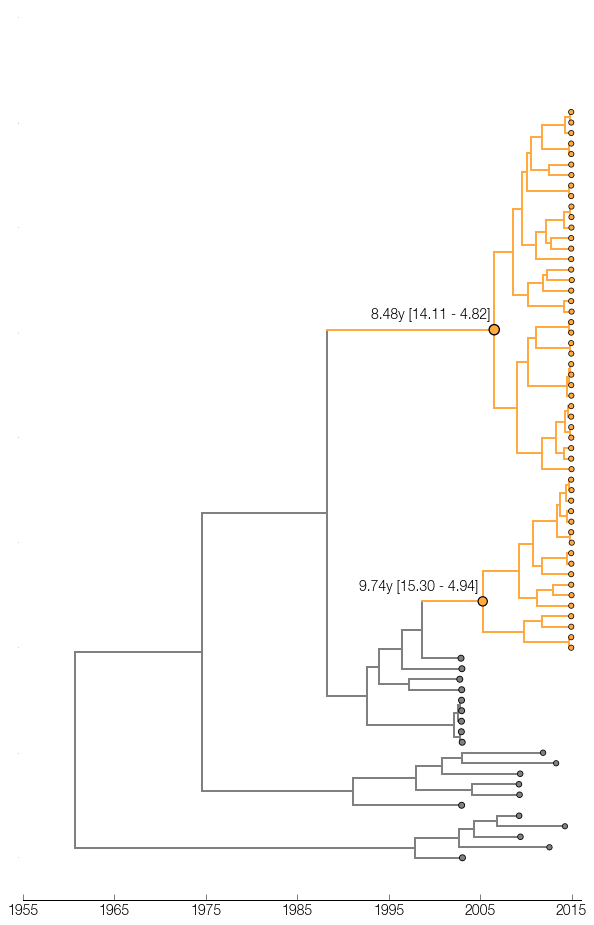

In [151]:
#plot HCV 6e tree!

#set up the plotting space
fig,ax1 = plt.subplots(figsize=(10,16),facecolor='white')
#set branch widths
branchWidth=2 #I tried out others, this looks the best.

#plot the tree
# x relates to sampling date, y is arbitrary and calc'd to separate tips evenly
for k in hcv6e_tree.Objects:
    #determine x and y coordinates for nodes and leaves
    x=k.absoluteTime
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    xp=k.parent.absoluteTime ## get x position of current node's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    #set up branch and node coloring.
    color = 'grey'
    if k.traits['sample_type'] == 'roka':
        color = '#FFA940'#tangerine color
    else:
        color = 'grey'
    
    # iterate through and draw the tree
    #draw leaves with circles
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        s=50-30*k.height/hcv6e_tree.treeHeight #s is the size of the tip circle
        ax1.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip, highest zorder means on top of everything else
        ax1.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath (zorder is one less than face zorder)
    #draw nodes
    elif isinstance(k,bt.node) or k.branchType=='node':
        ax1.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=color,ls='-',zorder=9)
        #draw a circle on a specific node and annotate
        if k == hcv6eA_mrca:
            ax1.scatter(x,y,s=3*s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for node
            ax1.scatter(x,y,s=5*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            node_age_string = '{0:.2f}y'.format(k.traits['height_median']) + ' ' +'[{0:.2f} - {1:.2f}] '.format(k.traits['height_95%_HPD'][1],k.traits['height_95%_HPD'][0])
            ax1.text(x-13.5,y+1,node_age_string,size=14)
        if k == hcv6eB_mrca:
            ax1.scatter(x,y,s=3*s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for node
            ax1.scatter(x,y,s=5*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            node_age_string = '{0:.2f}y'.format(k.traits['height_median']) + ' ' +'[{0:.2f} - {1:.2f}] '.format(k.traits['height_95%_HPD'][1],k.traits['height_95%_HPD'][0])
            ax1.text(x-13.5,y+1,node_age_string,size=14)
            #add time to x and subtract something for y (0.2 yrs etc) va='top',ha='right'
    #plot the rest of the branches   
    ax1.plot([xp,x],[y,y],lw=branchWidth,color=color,ls='-',zorder=9) #branches should be plotted beneath tip circles.

#Remove lines from sides of plot that I don't like
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

# decide which axis labels and ticks should be visible on plot
ax1.tick_params(axis='x',labelsize=14,size=6)
ax1.tick_params(axis='y',labelsize=0,size=0)

#format axis limits
major_ticks = np.arange(1945, 2016, 10)                                              
ax1.set_xticks(major_ticks)                                                       
                                         
# Only show ticks on the bottom spine
ax1.xaxis.set_ticks_position('bottom')     

ax1.set_ylim(-4,len(hcv6e_tree.Objects)/2+10)
ax1.set_xlim(1955,2016)

plt.show()

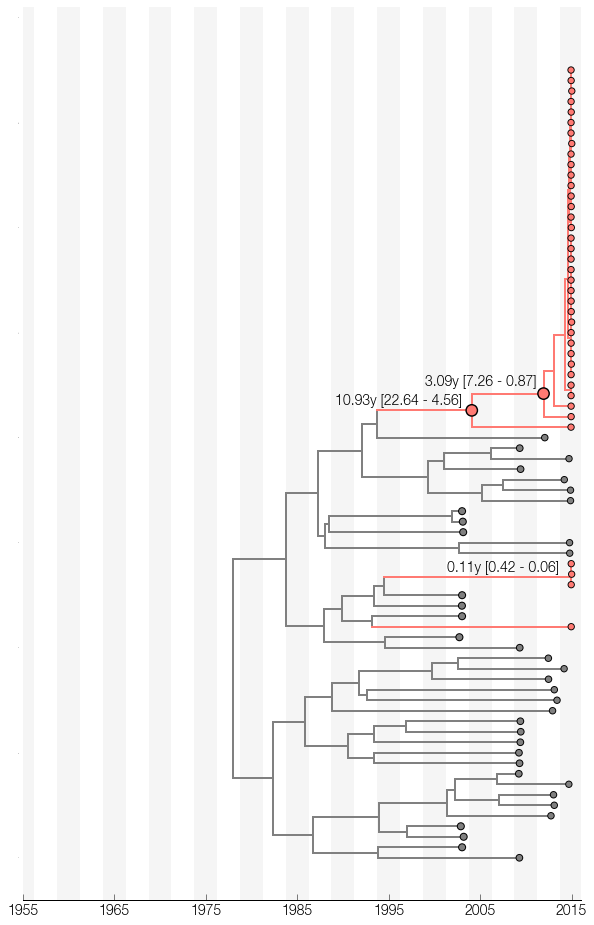

In [182]:
#plot HCV 1b tree!

#set up the plotting space
fig,ax2 = plt.subplots(figsize=(10,16),facecolor='white')
#set branch widths
branchWidth=2 #I tried out others, this looks the best.

#plot the tree
# x relates to sampling date, y is arbitrary and calc'd to separate tips evenly
for k in hcv1b_tree.Objects:
    #determine x and y coordinates for nodes and leaves
    x=k.absoluteTime
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    xp=k.parent.absoluteTime ## get x position of current node's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    #set up branch and node coloring.
    color = 'grey'
    if k.traits['sample_type'] == 'roka':
        color = '#ff7a73'#salmon color
    else:
        color = 'grey'
    
    # iterate through and draw the tree
    #draw leaves with circles
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        s=50-30*k.height/hcv6e_tree.treeHeight #s is the size of the tip circle
        ax2.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip, highest zorder means on top of everything else
        ax2.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath (zorder is one less than face zorder)
    #draw nodes
    elif isinstance(k,bt.node) or k.branchType=='node':
        ax2.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=color,ls='-',zorder=9)
        #draw a circle on a specific node and annotate
        if k == hcv1bA_mrca:
            ax2.scatter(x,y,s=3*s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for node
            ax2.scatter(x,y,s=5*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            node_age_string = '{0:.2f}y'.format(k.traits['height_median']) + ' ' +'[{0:.2f} - {1:.2f}] '.format(k.traits['height_95%_HPD'][1],k.traits['height_95%_HPD'][0])
            ax2.text(x-15,y+0.5,node_age_string,size=14)
        if k == hcv1bB_mrca:
            #ax2.scatter(x,y,s=3*s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for node
            #ax2.scatter(x,y,s=5*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            node_age_string = '{0:.2f}y'.format(k.traits['height_median']) + ' ' +'[{0:.2f} - {1:.2f}] '.format(k.traits['height_95%_HPD'][1],k.traits['height_95%_HPD'][0])
            ax2.text(x-13.5,y+0.5,node_age_string,size=14)
        if k == hcv1bAsubclade_mrca:
            ax2.scatter(x,y,s=3*s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for node
            ax2.scatter(x,y,s=5*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            node_age_string = '{0:.2f}y'.format(k.traits['height_median']) + ' ' +'[{0:.2f} - {1:.2f}] '.format(k.traits['height_95%_HPD'][1],k.traits['height_95%_HPD'][0])
            ax2.text(x-13,y+0.75,node_age_string,size=14)
            #add time to x and subtract something for y (0.2 yrs etc) va='top',ha='right'
    #plot the rest of the branches   
    ax2.plot([xp,x],[y,y],lw=branchWidth,color=color,ls='-',zorder=9) #branches should be plotted beneath tip circles.

## add grey bars
for x in range(1950,2016,5):
    ax2.axvspan(x-1.25,x+1.25,facecolor='k',edgecolor='none',alpha=0.04,zorder=0)

#Remove lines from sides of plot that I don't like
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# decide which axis labels and ticks should be visible on plot
ax2.tick_params(axis='x',labelsize=14,size=6)
ax2.tick_params(axis='y',labelsize=0,size=0)

#format axis limits
major_ticks = np.arange(1945, 2016, 10)                                              
ax2.set_xticks(major_ticks)                                                       
                                         
# Only show ticks on the bottom spine
ax2.xaxis.set_ticks_position('bottom')     

ax2.set_ylim(-4,len(hcv6e_tree.Objects)/2+10)
ax2.set_xlim(1955,2016)

plt.show()

## Now, make figures for ML trees

I've opened the .nexus files in BEAST and saved them so that they will be in a format that baltic will like them. I think the tree string by itself would work too, but this allows me to label the support trait the way I want (eg: `bootstrap`) which should just make things a little easier to work with.

In [4]:
# Read in mcc files for HIV env, prot, and RT
HIVenv_ml_path='/Users/alliblk/Desktop/gitrepos/roka/HIV/max_likelihood/env_roka_controls_bootstrap.nexus'
HIVprot_ml_path='/Users/alliblk/Desktop/gitrepos/roka/HIV/max_likelihood/prot_roka_controls_bootstrap.nexus'
HIVrt_ml_path='/Users/alliblk/Desktop/gitrepos/roka/HIV/max_likelihood/rt_roka_controls_bootstrap.nexus'

tipFlag=False ## used to keep track of where we are in FigTree format
hivenv_tips={} ## dictionary of tip code to full tip name
hivprot_tips={}
hivrt_tips={}

for line in open(HIVenv_ml_path,'rU'): ## iterate through FigTree file's lines
    line = line.strip('\n') ## strip newline characters from each line
    tip_count_match =re.search('dimensions ntax=([0-9]+);',line.lower()) ## check how many tips you have
    #print tip_count
    if tip_count_match is not None:
        tipNumenv=int(tip_count_match.group(1)) 

print 'number of tips in HIV env ML tree: ' + str(tipNumenv)

for line in open(HIVprot_ml_path,'rU'): ## iterate through FigTree file's lines
    line = line.strip('\n') ## strip newline characters from each line
    tip_count_match =re.search('dimensions ntax=([0-9]+);',line.lower()) ## check how many tips you have
    #print tip_count
    if tip_count_match is not None:
        tipNumprot=int(tip_count_match.group(1)) 

print 'number of tips in HIV prot ML tree: ' + str(tipNumprot)

for line in open(HIVrt_ml_path,'rU'): ## iterate through FigTree file's lines
    line = line.strip('\n') ## strip newline characters from each line
    tip_count_match =re.search('dimensions ntax=([0-9]+);',line.lower()) ## check how many tips you have
    #print tip_count
    if tip_count_match is not None:
        tipNumrt=int(tip_count_match.group(1)) 

print 'number of tips in HIV rt ML tree: ' + str(tipNumrt)

number of tips in HIV env ML tree: 230
number of tips in HIV prot ML tree: 219
number of tips in HIV rt ML tree: 219


### Slight change needed to import code when importing ML trees from RAxML (processed by FigTree) versus BEAST trees.

With BEAST trees, the tree string starts as `tree TREE<some number> = [&R]` whereas for the raxml trees that tree string starts as `tree tree_<some number> = [&R]`. You need to change the regex match code or else you won't be able to read the tree in.

In [5]:
for line in open(HIVenv_ml_path,'rU'):
    line = line.strip('\n')
    tree_string_match =re.search('tree tree_([0-9]+) = \[&R\]',line) ## search for beginning of tree string in BEAST format
    if tree_string_match is not None:
        treeString_start = line.index('(') ## tree string starts where the first '(' is in the line
        #print treeString_start
        hivenvml_tree = bt.tree() ## new instance of tree
        bt.make_tree(line[treeString_start:],hivenvml_tree) ## send tree string to make_tree function, provide an empty tree object

for line in open(HIVprot_ml_path,'rU'):
    line = line.strip('\n')
    tree_string_match =re.search('tree tree_([0-9]+) = \[&R\]',line) ## search for beginning of tree string in BEAST format
    if tree_string_match is not None:
        treeString_start = line.index('(') ## tree string starts where the first '(' is in the line
        #print treeString_start
        hivprotml_tree = bt.tree() ## new instance of tree
        bt.make_tree(line[treeString_start:],hivprotml_tree)

for line in open(HIVrt_ml_path,'rU'):
    line = line.strip('\n')
    tree_string_match =re.search('tree tree_([0-9]+) = \[&R\]',line) ## search for beginning of tree string in BEAST format
    if tree_string_match is not None:
        treeString_start = line.index('(') ## tree string starts where the first '(' is in the line
        #print treeString_start
        hivrtml_tree = bt.tree() ## new instance of tree
        bt.make_tree(line[treeString_start:],hivrtml_tree)

print hivenvml_tree
print hivprotml_tree
print hivrtml_tree

<baltic_four.tree instance at 0x10a211680>
<baltic_four.tree instance at 0x10a2114d0>
<baltic_four.tree instance at 0x10ca41638>


In [6]:
for line in open(HIVenv_ml_path,'rU'):
    line = line.strip('\n')
    if tipFlag==True:
        tip_match = re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|?]+)',line) 
        ## look for tip name map, where each tip is given an integer to represent it in tree
        ## note that if you're reading in a file that was read in figtree this won't be there
        ## you'll just have the proper names there.
        if tip_match is not None:
            hivenv_tips[tip_match.group(1)]=tip_match.group(2).strip("'")
            ## if you give tips an integer (in the form of a string), it will return the full name of the tip
        elif ';' not in line: ## something's wrong - nothing that matches the tip regex is being captured where it should be in the file
            print 'tip not captured by regex:',line.replace('\t','')

    if 'translate' in line.lower(): ## start looking for tips, the tips text block is starting 
        tipFlag=True
    if ';' in line: ## stop looking for tips, the tips text block has ended
        tipFlag=False

print "Number of objects found in hiv env ml tree string: %d"%(len(hivenvml_tree.Objects))

#########

for line in open(HIVprot_ml_path,'rU'):
    line = line.strip('\n')
    if tipFlag==True:
        tip_match = re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|?]+)',line) 
        ## look for tip name map, where each tip is given an integer to represent it in tree
        ## note that if you're reading in a file that was read in figtree this won't be there
        ## you'll just have the proper names there.
        if tip_match is not None:
            hivprot_tips[tip_match.group(1)]=tip_match.group(2).strip("'")
            ## if you give tips an integer (in the form of a string), it will return the full name of the tip
        elif ';' not in line: ## something's wrong - nothing that matches the tip regex is being captured where it should be in the file
            print 'tip not captured by regex:',line.replace('\t','')

    if 'translate' in line.lower(): ## start looking for tips, the tips text block is starting 
        tipFlag=True
    if ';' in line: ## stop looking for tips, the tips text block has ended
        tipFlag=False

print "Number of objects found in hiv prot ml tree string: %d"%(len(hivprotml_tree.Objects))

#########

for line in open(HIVrt_ml_path,'rU'):
    line = line.strip('\n')
    if tipFlag==True:
        tip_match = re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|?]+)',line) 
        ## look for tip name map, where each tip is given an integer to represent it in tree
        ## note that if you're reading in a file that was read in figtree this won't be there
        ## you'll just have the proper names there.
        if tip_match is not None:
            hivrt_tips[tip_match.group(1)]=tip_match.group(2).strip("'")
            ## if you give tips an integer (in the form of a string), it will return the full name of the tip
        elif ';' not in line: ## something's wrong - nothing that matches the tip regex is being captured where it should be in the file
            print 'tip not captured by regex:',line.replace('\t','')

    if 'translate' in line.lower(): ## start looking for tips, the tips text block is starting 
        tipFlag=True
    if ';' in line: ## stop looking for tips, the tips text block has ended
        tipFlag=False

print "Number of objects found in hiv rt ml tree string: %d"%(len(hivrtml_tree.Objects))


Number of objects found in hiv env ml tree string: 458
Number of objects found in hiv prot ml tree string: 436
Number of objects found in hiv rt ml tree string: 436


### ISSUE!

Why do we have 2(TipNum) - 2 objects in ml tree string rather than the 2(TipNum) - 1 objects which is what we usually get when we read in BEAST trees. 

See code below, number of leaves is correct but there are n-2 nodes rather than n-1 nodes...why?

In [7]:
envleafcounter = 0
for k in hivenvml_tree.Objects:
    if isinstance (k,bt.leaf) or k.branchType=='leaf':
        envleafcounter +=1
print envleafcounter


envnodecounter = 0
for k in hivenvml_tree.Objects:
    if isinstance (k,bt.node) or k.branchType=='node':
        envnodecounter +=1
print envnodecounter
#Number of nodes should be n_leaves-1...what's happening here?  

230
228


In [8]:
hivenvml_tree.sortBranches(descending=False)
hivprotml_tree.sortBranches(descending=False)
hivrtml_tree.sortBranches(descending=False)

In [9]:
#assign roka trait to allow branch/node coloring instead of just leaf coloring
#by whether a sample came from roka or is a control.
for k in hivenvml_tree.Objects:
    if isinstance(k,bt.leaf) or k.branchType =='leaf':
        if 'NCHADS' in k.numName.split('|')[0]:
            k.traits["sample_type"] = 'roka'
        else:
            k.traits["sample_type"] = 'control'
    elif isinstance(k,bt.node) or k.branchType =='node':
       continue 

#Then build in the nodes moving by NODE DEPTH

for k in hivenvml_tree.Objects:
    if isinstance(k,bt.node) or k.branchType =='node':
        roka_count = 0
        for leaf in k.leaves:
            if 'NCHADS' in leaf.split('|')[0]:
                roka_count +=1
        if roka_count == 2:#if both descendents of a depth 1 node are roka samples, then this node is in roka too
            k.traits['sample_type'] = 'roka'
        elif roka_count < 2:#one or none of node descendents are roka
            k.traits['sample_type'] = 'control'       

#and then continue to do this node calling node depth by node depth in the tree.
#eg the next possible number of descendents a node could have is 3 children.
for i in xrange(2,len(hivenvml_tree.Objects)):
    for k in hivenvml_tree.Objects:
        if isinstance(k,bt.node) or k.branchType =='node':
            if len(k.leaves) == i:
                roka_count = 0
                for leaf in k.leaves:
                    if 'NCHADS' in leaf.split('|')[0]:
                        roka_count += 1
                if roka_count == i: #if all descendents of this node are in roka
                    k.traits['sample_type'] = 'roka'
                elif roka_count < i:
                    k.traits['sample_type'] = 'control'


In [10]:
# Get mrca's all set up!
roka_nonia = ['NCHADS116', 'NCHADS171', 'NCHADS184', 'NCHADS185']
roka_ml_outbreak = []
for k in hivenvml_tree.Objects:
    if isinstance(k,bt.leaf) or k.branchType == 'leaf':
        if k.numName.split('|')[0] not in roka_nonia and 'NCHADS' in k.numName.split('|')[0]:
            roka_ml_outbreak.append(k.numName)

#print roka_ml_outbreak
hivenv_ml_roka_mrca = hivenvml_tree.commonAncestor(roka_ml_outbreak,True)
print hivenv_ml_roka_mrca

<baltic_four.node instance at 0x10a6f77e8>


In [14]:
#designate which font to use. To use others just use different ttf files 
#if ttf files not already in there, may need to do fondu conversion of dfont files and move in.
font_path = '/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/HelveticaNeueThin.ttf'
font_properties = fm.FontProperties(fname=font_path)
print font_properties
mpl.rcParams['font.family'] = font_properties.get_name()

#designate some font characteristics
mpl.rcParams['font.weight']=100
mpl.rcParams['axes.labelweight']=100
mpl.rcParams['font.size']=14


:family=Helvetica,HelveticaNeue,HelveticaLight,sans-serif:style=normal:variant=normal:weight=400:stretch=normal:file=/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/HelveticaNeueThin.ttf:size=10.0


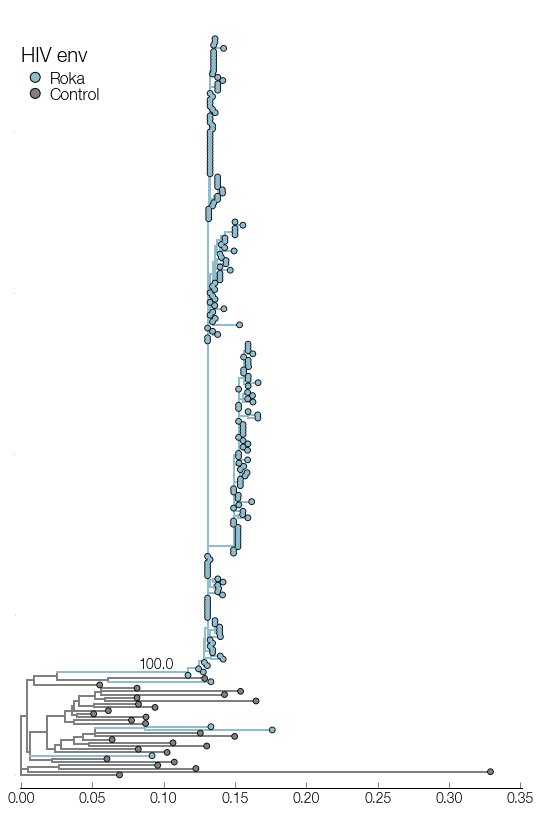

In [48]:
#set up the plotting space
fig,ax = plt.subplots(figsize=(9,14),facecolor='white')
#set branch widths
branchWidth=2 #I tried out others, this looks the best.
hivenvml_tree.sortBranches(descending=False)

#plot the tree
#x relates to sampling date, y is arbitrary and calc'd to separate tips evenly
for k in hivenvml_tree.Objects:
    #determine x and y coordinates for nodes and leaves
    x=k.height
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    xp=k.parent.height ## get x position of current node's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    #set up branch and node coloring.
    color = 'grey'
    if k.traits['sample_type'] == 'roka':
        color = '#8FBDD0'#'lightblue'
    else:
        color = 'grey'
    
    # iterate through and draw the tree
    #draw leaves with circles
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        s=25
        ax.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip, highest zorder means on top of everything else
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath (zorder is one less than face zorder)
    #draw nodes
    elif isinstance(k,bt.node) or k.branchType=='node':
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=color,ls='-',zorder=9)
        if k == hivenv_ml_roka_mrca:
            #ax.scatter(x,y,s=4*s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for node
            #ax.scatter(x,y,s=6*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax.text(x-0.035,y+1,k.traits['bootstrap'])
    ax.plot([xp,x],[y,y],lw=branchWidth,color=color,ls='-',zorder=9) #branches should be plotted beneath tip circles.

#Remove lines from sides of plot that I don't like
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

# decide which axis labels and ticks should be visible on plot
ax.tick_params(axis='x',labelsize=14,size=6)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.xaxis.set_ticks_position('bottom') 

#format axis limits
#major_ticks = np.arange(1935, 2016, 10)                                              
#ax.set_xticks(major_ticks)                                                       
                                         
# Only show ticks on the bottom spine
#ax.xaxis.set_ticks_position('bottom')     

ax.set_ylim(-4,len(hivenvml_tree.Objects)/2+10)
ax.set_xlim(-0.001,0.351)

#make legend
ax.text(0,222, 'HIV env', size=20)
ax.text(0.02,215, 'Roka', size=16)
ax.text(0.02,210, 'Control', size=16)

ax.scatter(0.01,217,s=80,facecolor='#8FBDD0',edgecolor='none',zorder=11) ## plot circle for node
ax.scatter(0.01,217,s=120,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath
ax.scatter(0.01,212,s=80,facecolor='grey',edgecolor='none',zorder=11) ## plot circle for node
ax.scatter(0.01,212,s=120,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath

plt.show()
plt.figure()
fig.savefig('env_mltree_baltic.pdf')
fig.savefig('env_mltree_baltic.png')

In [16]:
#assign roka trait to allow branch/node coloring instead of just leaf coloring
#by whether a sample came from roka or is a control.

# START WITH PROT
for k in hivprotml_tree.Objects:
    if isinstance(k,bt.leaf) or k.branchType =='leaf':
        if 'NCHADS' in k.numName.split('|')[0]:
            k.traits["sample_type"] = 'roka'
        else:
            k.traits["sample_type"] = 'control'
    elif isinstance(k,bt.node) or k.branchType =='node':
       continue 

#Then build in the nodes moving by NODE DEPTH

for k in hivprotml_tree.Objects:
    if isinstance(k,bt.node) or k.branchType =='node':
        roka_count = 0
        for leaf in k.leaves:
            if 'NCHADS' in leaf.split('|')[0]:
                roka_count +=1
        if roka_count == 2:#if both descendents of a depth 1 node are roka samples, then this node is in roka too
            k.traits['sample_type'] = 'roka'
        elif roka_count < 2:#one or none of node descendents are roka
            k.traits['sample_type'] = 'control'       

#and then continue to do this node calling node depth by node depth in the tree.
#eg the next possible number of descendents a node could have is 3 children.
for i in xrange(2,len(hivprotml_tree.Objects)):
    for k in hivprotml_tree.Objects:
        if isinstance(k,bt.node) or k.branchType =='node':
            if len(k.leaves) == i:
                roka_count = 0
                for leaf in k.leaves:
                    if 'NCHADS' in leaf.split('|')[0]:
                        roka_count += 1
                if roka_count == i: #if all descendents of this node are in roka
                    k.traits['sample_type'] = 'roka'
                elif roka_count < i:
                    k.traits['sample_type'] = 'control'


In [17]:
#Then do the same thing for RT
for k in hivrtml_tree.Objects:
    if isinstance(k,bt.leaf) or k.branchType =='leaf':
        if 'NCHADS' in k.numName.split('|')[0]:
            k.traits["sample_type"] = 'roka'
        else:
            k.traits["sample_type"] = 'control'
    elif isinstance(k,bt.node) or k.branchType =='node':
       continue 

#Then build in the nodes moving by NODE DEPTH

for k in hivrtml_tree.Objects:
    if isinstance(k,bt.node) or k.branchType =='node':
        roka_count = 0
        for leaf in k.leaves:
            if 'NCHADS' in leaf.split('|')[0]:
                roka_count +=1
        if roka_count == 2:#if both descendents of a depth 1 node are roka samples, then this node is in roka too
            k.traits['sample_type'] = 'roka'
        elif roka_count < 2:#one or none of node descendents are roka
            k.traits['sample_type'] = 'control'       

#and then continue to do this node calling node depth by node depth in the tree.
#eg the next possible number of descendents a node could have is 3 children.
for i in xrange(2,len(hivrtml_tree.Objects)):
    for k in hivrtml_tree.Objects:
        if isinstance(k,bt.node) or k.branchType =='node':
            if len(k.leaves) == i:
                roka_count = 0
                for leaf in k.leaves:
                    if 'NCHADS' in leaf.split('|')[0]:
                        roka_count += 1
                if roka_count == i: #if all descendents of this node are in roka
                    k.traits['sample_type'] = 'roka'
                elif roka_count < i:
                    k.traits['sample_type'] = 'control'

#### Note to self:

I should definitely turn the above loops into functions, but there's so many arguments at this point that I'd need that a function would need to take in too many arguments. What I really need to do is just have a lot more modular funtions that start earlier, eg a function that standardizes taxon names so that the delimiter and indices can be hardcoded.

In [18]:
roka_prot_outbreak = []
roka_rt_outbreak = []

for k in hivprotml_tree.Objects:
    if isinstance(k,bt.leaf) or k.branchType == 'leaf':
        if k.numName.split('|')[0] not in roka_nonia and 'NCHADS' in k.numName.split('|')[0]:
            roka_prot_outbreak.append(k.numName)
    
for k in hivrtml_tree.Objects:
    if isinstance(k,bt.leaf) or k.branchType == 'leaf':
        if k.numName.split('|')[0] not in roka_nonia and 'NCHADS' in k.numName.split('|')[0]:
            roka_rt_outbreak.append(k.numName)

hivprot_ml_roka_mrca = hivprotml_tree.commonAncestor(roka_prot_outbreak,True)
hivrt_ml_roka_mrca = hivrtml_tree.commonAncestor(roka_rt_outbreak,True)

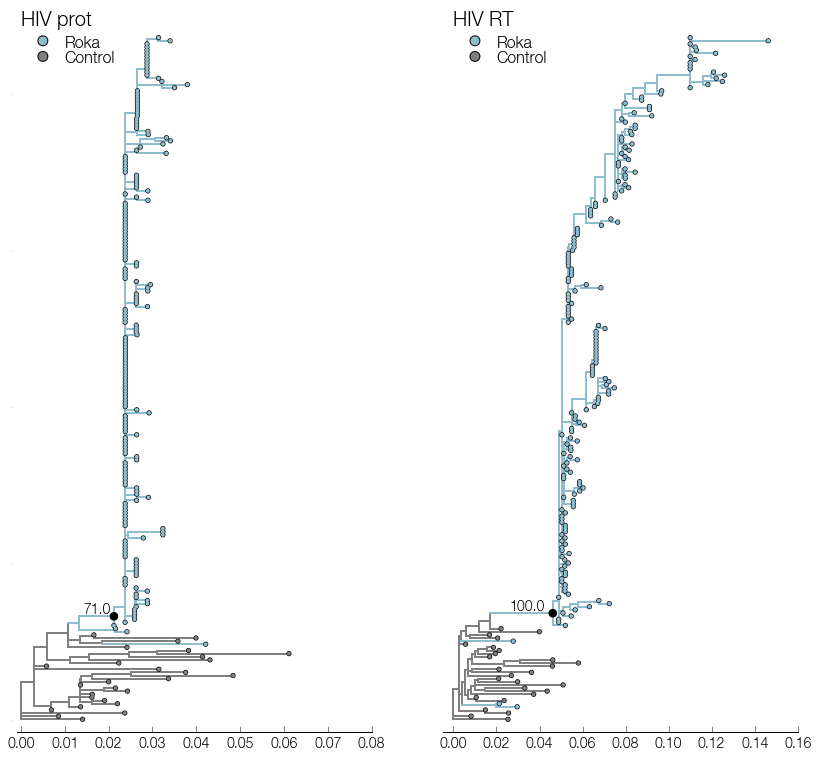

In [49]:
#set up the plotting space
fig, (ax3, ax4) = plt.subplots(1,2, sharey=True, figsize=(14,13),facecolor='white')
branchWidth=2 #I tried out others, this looks the best.

hivprotml_tree.sortBranches(descending=False)
hivrtml_tree.sortBranches(descending=False)

for k in hivprotml_tree.Objects:
    #determine x and y coordinates for nodes and leaves
    x=k.height
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    xp=k.parent.height ## get x position of current node's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    #set up branch and node coloring.
    color = 'grey'
    if k.traits['sample_type'] == 'roka':
        color = '#8FBDD0'#'lightblue'
    else:
        color = 'grey'
    
    # iterate through and draw the tree
    #draw leaves with circles
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        s=15
        ax3.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip, highest zorder means on top of everything else
        ax3.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath (zorder is one less than face zorder)
    #draw nodes
    elif isinstance(k,bt.node) or k.branchType=='node':
        ax3.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=color,ls='-',zorder=9)
        if k == hivprot_ml_roka_mrca:
            #ax.scatter(x,y,s=4*s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for node
            ax3.scatter(x,y,s=5*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax3.text(x-0.007,y+1,k.traits['bootstrap'])
    ax3.plot([xp,x],[y,y],lw=branchWidth,color=color,ls='-',zorder=9) #branches should be plotted beneath tip circles.

#Remove lines from sides of plot that I don't like
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
#ax3.spines['bottom'].set_visible(False)

# decide which axis labels and ticks should be visible on plot
ax3.tick_params(axis='x',labelsize=14,size=6)
ax3.tick_params(axis='y',labelsize=0,size=0)
ax3.xaxis.set_ticks_position('bottom') 

ax3.set_ylim(-4,len(hivprotml_tree.Objects)/2+10)
ax3.set_xlim(-0.001,0.08)

#make legend
ax3.text(0,222, 'HIV prot', size=20)
ax3.text(0.01,215, 'Roka', size=16)
ax3.text(0.01,210, 'Control', size=16)

ax3.scatter(0.005,217,s=80,facecolor='#8FBDD0',edgecolor='none',zorder=11) ## plot circle for node
ax3.scatter(0.005,217,s=120,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath
ax3.scatter(0.005,212,s=80,facecolor='grey',edgecolor='none',zorder=11) ## plot circle for node
ax3.scatter(0.005,212,s=120,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath


###########################


for k in hivrtml_tree.Objects:
    #determine x and y coordinates for nodes and leaves
    x=k.height
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    xp=k.parent.height ## get x position of current node's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    #set up branch and node coloring.
    color = 'grey'
    if k.traits['sample_type'] == 'roka':
        color = '#8FBDD0'#'lightblue'
    else:
        color = 'grey'
    
    # iterate through and draw the tree
    #draw leaves with circles
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        s=15
        ax4.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip, highest zorder means on top of everything else
        ax4.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath (zorder is one less than face zorder)
    #draw nodes
    elif isinstance(k,bt.node) or k.branchType=='node':
        ax4.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=color,ls='-',zorder=9)
        if k == hivrt_ml_roka_mrca:
            #ax.scatter(x,y,s=4*s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for node
            ax4.scatter(x,y,s=5*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax4.text(x-0.02,y+1,k.traits['bootstrap'])
    ax4.plot([xp,x],[y,y],lw=branchWidth,color=color,ls='-',zorder=9) #branches should be plotted beneath tip circles.

#Remove lines from sides of plot that I don't like
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
#ax4.spines['bottom'].set_visible(False)

# decide which axis labels and ticks should be visible on plot
ax4.tick_params(axis='x',labelsize=14,size=6)
ax4.tick_params(axis='y',labelsize=0,size=0)
ax4.xaxis.set_ticks_position('bottom') 

ax4.set_ylim(-4,len(hivrtml_tree.Objects)/2+10)
ax4.set_xlim(-0.005,0.16)

#make legend
ax4.text(0,222, 'HIV RT', size=20)
ax4.text(0.02,215, 'Roka', size=16)
ax4.text(0.02,210, 'Control', size=16)

ax4.scatter(0.01,217,s=80,facecolor='#8FBDD0',edgecolor='none',zorder=11) ## plot circle for node
ax4.scatter(0.01,217,s=120,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath
ax4.scatter(0.01,212,s=80,facecolor='grey',edgecolor='none',zorder=11) ## plot circle for node
ax4.scatter(0.01,212,s=120,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath


plt.show()
plt.figure()
fig.savefig('protRT_mltree_baltic.pdf')
fig.savefig('protRT_mltree_baltic.png')

In [51]:
# Read in mcc files
HCV6e_ml_path='/Users/alliblk/Desktop/gitrepos/roka/HCV/max_likelihood/figtree_reroot_hcv6e.nexus'
HCV1b_ml_path='/Users/alliblk/Desktop/gitrepos/roka/HCV/max_likelihood/figtree_reroot_hcv1b.nexus'

tipFlag=False ## used to keep track of where we are in FigTree format
hcv6eml_tips={} ## dictionary of tip code to full tip name
hcv1bml_tips={}

for line in open(HCV6e_ml_path,'rU'): ## iterate through FigTree file's lines
    line = line.strip('\n') ## strip newline characters from each line
    tip_count_match =re.search('dimensions ntax=([0-9]+);',line.lower()) ## check how many tips you have
    #print tip_count
    if tip_count_match is not None:
        tipNum6e=int(tip_count_match.group(1)) 

for line in open(HCV1b_ml_path,'rU'): ## iterate through FigTree file's lines
    line = line.strip('\n') ## strip newline characters from each line
    tip_count_match =re.search('dimensions ntax=([0-9]+);',line.lower()) ## check how many tips you have
    #print tip_count
    if tip_count_match is not None:
        tipNum1b=int(tip_count_match.group(1)) 


In [24]:
#import and parse trees

#get tree strings out of file and make tree object
for line in open(HCV6e_ml_path,'rU'):
    line = line.strip('\n')
    tree_string_match =re.search('tree tree_([0-9]+) = \[&R\]',line) ## search for beginning of tree string in BEAST format
    if tree_string_match is not None:
        treeString_start = line.index('(') ## tree string starts where the first '(' is in the line
        #print treeString_start
        hcv6e_ml_tree = bt.tree() ## new instance of tree
        bt.make_tree(line[treeString_start:],hcv6e_ml_tree) ## send tree string to make_tree function, provide an empty tree object

for line in open(HCV1b_ml_path,'rU'):
    line = line.strip('\n')
    tree_string_match =re.search('tree tree_([0-9]+) = \[&R\]',line) ## search for beginning of tree string in BEAST format
    if tree_string_match is not None:
        treeString_start = line.index('(') ## tree string starts where the first '(' is in the line
        #print treeString_start
        hcv1b_ml_tree = bt.tree() ## new instance of tree
        bt.make_tree(line[treeString_start:],hcv1b_ml_tree)
###


#Need to traverse and draw the tree. 
#By calling .sortBranches this does both of those functions
#If you don't traverse the tree then you will import traits, but you won't get the x and y values of the nodes and leaves
#and so you won't be able to plot the tree.

hcv1b_ml_tree.sortBranches(descending=False)
hcv1b_ml_tree.treeStats()

hcv6e_ml_tree.sortBranches(descending=False)
hcv6e_ml_tree.treeStats()


#####
#start reading in node and leaf objects to tree object made above.
for line in open(HCV6e_ml_path,'rU'):
    line = line.strip('\n')
    if tipFlag==True:
        tip_match = re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|?]+)',line) 
        ## look for tip name map, where each tip is given an integer to represent it in tree
        ## note that if you're reading in a file that was read in figtree this won't be there
        ## you'll just have the proper names there.
        if tip_match is not None:
            hcv6eml_tips[tip_match.group(1)]=tip_match.group(2).strip("'")
            ## if you give tips an integer (in the form of a string), it will return the full name of the tip
        elif ';' not in line: ## something's wrong - nothing that matches the tip regex is being captured where it should be in the file
            print 'tip not captured by regex:',line.replace('\t','')

    if 'translate' in line.lower(): ## start looking for tips, the tips text block is starting 
        tipFlag=True
    if ';' in line: ## stop looking for tips, the tips text block has ended
        tipFlag=False

print "Number of objects found in hcv6e tree string: %d"%(len(hcv6e_ml_tree.Objects))

#########

for line in open(HCV1b_ml_path,'rU'):
    line = line.strip('\n')
    if tipFlag==True:
        tip_match = re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|?]+)',line) 
        ## look for tip name map, where each tip is given an integer to represent it in tree
        if tip_match is not None:
            hcv1bml_tips[tip_match.group(1)]=tip_match.group(2).strip("'") 
        elif ';' not in line: ## something's wrong - nothing that matches the tip regex is being captured where it should be in the file
            print 'tip not captured by regex:',line.replace('\t','')

    if 'translate' in line.lower(): ## start looking for tips, the tips text block is starting 
        tipFlag=True
    if ';' in line: ## stop looking for tips, the tips text block has ended
        tipFlag=False

print "Number of objects found in hcv1b tree string: %d"%(len(hcv1b_ml_tree.Objects))


FigTree comment found, ignoring
FigTree comment found, ignoring

Tree height: 0.195671
Tree length: 1.667510

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 151 (75 nodes and 76 leaves)


Tree height: 0.220860
Tree length: 1.230482

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 143 (71 nodes and 72 leaves)

Number of objects found in hcv6e tree string: 143
Number of objects found in hcv1b tree string: 151


In [25]:
for k in hcv6e_ml_tree.Objects:
    if isinstance(k,bt.leaf) or k.branchType =='leaf':
        if 'NCHADS' in k.numName.split('|')[0]:
            k.traits["sample_type"] = 'roka'
        else:
            k.traits["sample_type"] = 'control'
    elif isinstance(k,bt.node) or k.branchType =='node':
       continue 

#Then build in the nodes moving by NODE DEPTH

for k in hcv6e_ml_tree.Objects:
    if isinstance(k,bt.node) or k.branchType =='node':
        roka_count = 0
        for leaf in k.leaves:
            if 'NCHADS' in leaf.split('|')[0]:
                roka_count +=1
        if roka_count == 2:#if both descendents of a depth 1 node are roka samples, then this node is in roka too
            k.traits['sample_type'] = 'roka'
        elif roka_count < 2:#one or none of node descendents are roka
            k.traits['sample_type'] = 'control'       

#and then continue to do this node calling node depth by node depth in the tree.
#eg the next possible number of descendents a node could have is 3 children.
for i in xrange(2,len(hcv6e_ml_tree.Objects)):
    for k in hcv6e_ml_tree.Objects:
        if isinstance(k,bt.node) or k.branchType =='node':
            if len(k.leaves) == i:
                roka_count = 0
                for leaf in k.leaves:
                    if 'NCHADS' in leaf.split('|')[0]:
                        roka_count += 1
                if roka_count == i: #if all descendents of this node are in roka
                    k.traits['sample_type'] = 'roka'
                elif roka_count < i:
                    k.traits['sample_type'] = 'control'


In [26]:
for k in hcv1b_ml_tree.Objects:
    if isinstance(k,bt.leaf) or k.branchType =='leaf':
        if 'NCHADS' in k.numName.split('|')[0]:
            k.traits["sample_type"] = 'roka'
        else:
            k.traits["sample_type"] = 'control'
    elif isinstance(k,bt.node) or k.branchType =='node':
       continue 

#Then build in the nodes moving by NODE DEPTH

for k in hcv1b_ml_tree.Objects:
    if isinstance(k,bt.node) or k.branchType =='node':
        roka_count = 0
        for leaf in k.leaves:
            if 'NCHADS' in leaf.split('|')[0]:
                roka_count +=1
        if roka_count == 2:#if both descendents of a depth 1 node are roka samples, then this node is in roka too
            k.traits['sample_type'] = 'roka'
        elif roka_count < 2:#one or none of node descendents are roka
            k.traits['sample_type'] = 'control'       

#and then continue to do this node calling node depth by node depth in the tree.
#eg the next possible number of descendents a node could have is 3 children.
for i in xrange(2,len(hcv1b_ml_tree.Objects)):
    for k in hcv1b_ml_tree.Objects:
        if isinstance(k,bt.node) or k.branchType =='node':
            if len(k.leaves) == i:
                roka_count = 0
                for leaf in k.leaves:
                    if 'NCHADS' in leaf.split('|')[0]:
                        roka_count += 1
                if roka_count == i: #if all descendents of this node are in roka
                    k.traits['sample_type'] = 'roka'
                elif roka_count < i:
                    k.traits['sample_type'] = 'control'

In [27]:
hcv6eAml_edge_taxa = ['NCHADS164|2014-12-19|6e', 'NCHADS162|2014-12-19|6e']
hcv6eAml_mrca = hcv6e_ml_tree.commonAncestor(hcv6eAml_edge_taxa, numName=True)

hcv6eBml_edge_taxa = ['NCHADS212|2015-01-06|6e', 'R006232|2002-12-20|6e']
hcv6eBml_mrca = hcv6e_ml_tree.commonAncestor(hcv6eBml_edge_taxa, numName=True)

hcv6ebasal_edge_taxa = ['NCHADS164|2014-12-19|6e', 'R006232|2002-12-20|6e']
hcv6ebasal_mrca = hcv6e_ml_tree.commonAncestor(hcv6ebasal_edge_taxa, numName=True)

#######

hcv1bAml_edge_taxa = ['NCHADS161|2014-12-19|1b','NCHADS121|2014-12-17|1b']
hcv1bAml_mrca = hcv1b_ml_tree.commonAncestor(hcv1bAml_edge_taxa, numName=True)

hcv1bBml_edge_taxa = ['NCHADS186|2014-12-22|1b', 'NCHADS196|2014-12-23|1b']
hcv1bBml_mrca = hcv1b_ml_tree.commonAncestor(hcv1bBml_edge_taxa, numName=True)

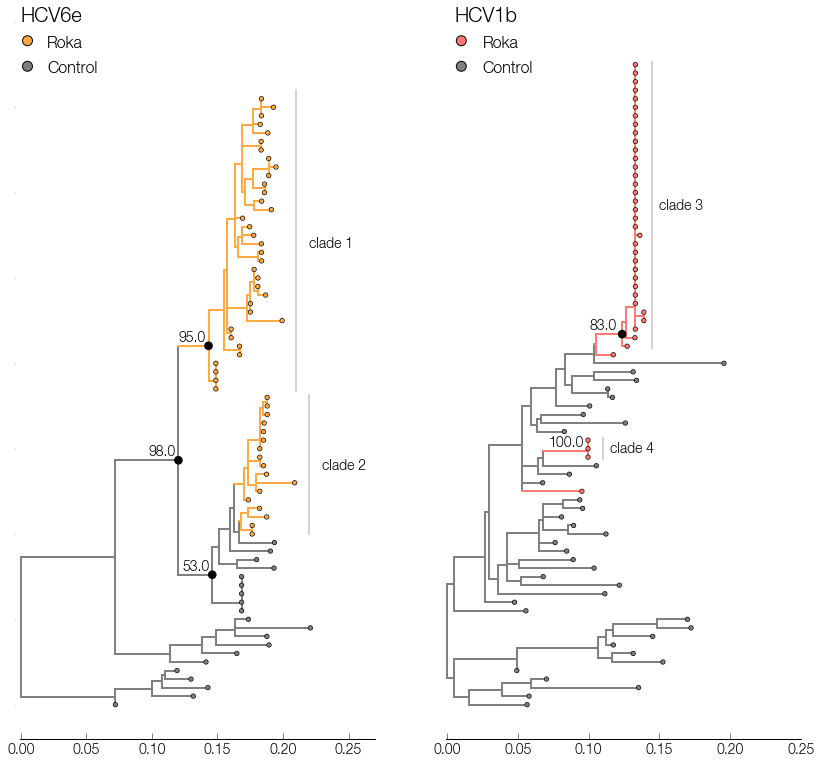

In [45]:
#set up the plotting space
fig, (ax5, ax6) = plt.subplots(1,2, sharey=True, figsize=(14,13),facecolor='white')
branchWidth=2 #I tried out others, this looks the best.

hcv6e_ml_tree.sortBranches(descending = False)
hcv1b_ml_tree.sortBranches(descending = False)

for k in hcv6e_ml_tree.Objects:
    #determine x and y coordinates for nodes and leaves
    x=k.height
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    xp=k.parent.height ## get x position of current node's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    #set up branch and node coloring.
    color = 'grey'
    if k.traits['sample_type'] == 'roka':
        color = '#FFA940'
    else:
        color = 'grey'
    
    # iterate through and draw the tree
    #draw leaves with circles
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        s=15
        ax5.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip, highest zorder means on top of everything else
        ax5.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath (zorder is one less than face zorder)
    #draw nodes
    elif isinstance(k,bt.node) or k.branchType=='node':
        ax5.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=color,ls='-',zorder=9)
        if k == hcv6eAml_mrca:
            #ax5.scatter(x,y,s=4*s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for node
            ax5.scatter(x,y,s=5*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax5.text(x-0.023,y+0.5,k.traits['bootstrap'])
        if k == hcv6eBml_mrca:
            #ax5.scatter(x,y,s=4*s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for node
            ax5.scatter(x,y,s=5*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax5.text(x-0.023,y+0.5,k.traits['bootstrap'])
        if k == hcv6ebasal_mrca:
            #ax5.scatter(x,y,s=4*s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for node
            ax5.scatter(x,y,s=5*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax5.text(x-0.023,y+0.5,k.traits['bootstrap'])
    ax5.plot([xp,x],[y,y],lw=branchWidth,color=color,ls='-',zorder=9) #branches should be plotted beneath tip circles.

#Remove lines from sides of plot that I don't like
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['left'].set_visible(False)
#ax3.spines['bottom'].set_visible(False)

# decide which axis labels and ticks should be visible on plot
ax5.tick_params(axis='x',labelsize=14,size=6)
ax5.tick_params(axis='y',labelsize=0,size=0)
ax5.xaxis.set_ticks_position('bottom') 

ax5.set_ylim(-4,len(hcv6e_ml_tree.Objects)/2+10)
ax5.set_xlim(-0.001,0.27)

#make legend
ax5.text(0,80, 'HCV6e', size=20)
ax5.text(0.02,77, 'Roka', size=16)
ax5.text(0.02,74, 'Control', size=16)

ax5.scatter(0.005,77.8,s=80,facecolor='#FFA940',edgecolor='none',zorder=11) ## plot circle for node
ax5.scatter(0.005,77.8,s=120,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath
ax5.scatter(0.005,74.8,s=80,facecolor='grey',edgecolor='none',zorder=11) ## plot circle for node
ax5.scatter(0.005,74.8,s=120,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath



###########################


for k in hcv1b_ml_tree.Objects:
    #determine x and y coordinates for nodes and leaves
    x=k.height
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    xp=k.parent.height ## get x position of current node's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    #set up branch and node coloring.
    color = 'grey'
    if k.traits['sample_type'] == 'roka':
        color = '#ff7a73'
    else:
        color = 'grey'
    
    # iterate through and draw the tree
    #draw leaves with circles
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        s=15
        ax6.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip, highest zorder means on top of everything else
        ax6.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath (zorder is one less than face zorder)
    #draw nodes
    elif isinstance(k,bt.node) or k.branchType=='node':
        ax6.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=color,ls='-',zorder=9)
        if k == hcv1bAml_mrca:
            #ax6.scatter(x,y,s=4*s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for node
            ax6.scatter(x,y,s=5*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax6.text(x-0.023,y+0.5,k.traits['bootstrap'])
        if k == hcv1bBml_mrca:
            #ax6.scatter(x,y,s=4*s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for node
            #ax6.scatter(x,y,s=5*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax6.text(x-0.028,y+0.5,k.traits['bootstrap'])
    ax6.plot([xp,x],[y,y],lw=branchWidth,color=color,ls='-',zorder=9) #branches should be plotted beneath tip circles.

#Remove lines from sides of plot that I don't like
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['left'].set_visible(False)
#ax4.spines['bottom'].set_visible(False)

# decide which axis labels and ticks should be visible on plot
ax6.tick_params(axis='x',labelsize=14,size=6)
ax6.tick_params(axis='y',labelsize=0,size=0)
ax6.xaxis.set_ticks_position('bottom') 

ax6.set_ylim(-4,len(hcv6e_ml_tree.Objects)/2+10)
ax6.set_xlim(-0.001,0.25)

#make legend
ax6.text(0.005,80, 'HCV1b', size=20)
ax6.text(0.025,77, 'Roka', size=16)
ax6.text(0.025,74, 'Control', size=16)

ax6.scatter(0.01,77.8,s=80,facecolor='#ff7a73',edgecolor='none',zorder=11) ## plot circle for node
ax6.scatter(0.01,77.8,s=120,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath
ax6.scatter(0.01,74.8,s=80,facecolor='grey',edgecolor='none',zorder=11) ## plot circle for node
ax6.scatter(0.01,74.8,s=120,facecolor='black',edgecolor='none',zorder=10) ## plot black circle underneath

ax6.plot((0.145, 0.145), (41.8, 75.3),'k-', linewidth=2,color='lightgrey' )
ax6.plot((0.11, 0.11), (28.8, 31.2),'k-', linewidth=2, color='lightgrey')
ax6.text(0.15,58, 'clade 3', size=14)
ax6.text(0.115,29.5, 'clade 4', size=14)

ax5.plot((0.21, 0.21), (36.8, 72),'k-', linewidth=2,color='lightgrey' )
ax5.plot((0.22, 0.22), (20, 36.3),'k-', linewidth=2, color='lightgrey')
ax5.text(0.22,53.5, 'clade 1', size=14)
ax5.text(0.23,27.5, 'clade 2', size=14)

plt.show()
plt.figure()
fig.savefig('hcv_mltree_baltic.pdf')
fig.savefig('hcv_mltree_baltic.png')